In [1]:
import torch
import numpy as np
from easy_transformer import EasyTransformer, EasyTransformerConfig
import easy_transformer
import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [36]:
vocab_size = 200
sequence_length = 10
batch_size = 64

tiny_cfg = EasyTransformerConfig(
    d_model=32,
    d_head=8,
    n_heads=4,
    d_mlp=32,
    n_layers=3,
    n_ctx=200,
    act_fn="solu_ln",
    d_vocab=vocab_size,
    normalization_type="LN",
    seed=0,
)
tiny_model = EasyTransformer(tiny_cfg).to(device)
cross_entropy_loss = torch.nn.CrossEntropyLoss(ignore_index=vocab_size - 1)

Moving model to device:  cpu
Moving model to device:  cpu


In [37]:
start_token = 0
sep_token = 1
ignore_token = 2
num_special_tokens = 3


In [38]:
from algorithmic_tasks.count_matches import gen
eval_inputs, eval_outputs = gen(1000,  tiny_model.cfg.d_vocab, 10, 3, 20)

In [39]:
eval_inputs

tensor([[5, 0, 3,  ..., 4, 3, 0],
        [3, 5, 0,  ..., 0, 4, 5],
        [5, 6, 8,  ..., 4, 3, 4],
        ...,
        [4, 8, 1,  ..., 7, 7, 0],
        [5, 6, 4,  ..., 4, 8, 0],
        [4, 1, 3,  ..., 1, 2, 8]])

In [40]:
def get_loss(model, inputs, outputs):
    inputs = inputs.to(device)
    outputs = outputs.to(device)
    
    output_logits = model(inputs, return_type="logits")

    seq_len = inputs.shape[1]

    loss = cross_entropy_loss(
        output_logits[:,:].reshape((-1,vocab_size)),
        outputs[:,:].reshape((-1,)))
    
    return loss

def evaluate_model(model, batch_size, print_output, number_to_print=0):
    vocab_size = model.cfg.d_vocab
    inputs,outputs = gen(batch_size,vocab_size,random.randint(2, 10), random.randint(2, 5), random.randint(7,150))

    loss = get_loss(model,inputs,outputs)

    if print_output:
      eval_loss = get_loss(model,eval_inputs, eval_outputs)
      print(eval_loss.item())

    return loss

In [ ]:
loss_history = []
print('Start training')
tiny_optimizer = torch.optim.Adam(tiny_model.parameters(), lr=4e-3)
loss = evaluate_model(tiny_model, batch_size=3000, print_output=True)
for epoch in tqdm.tqdm(range(30000)):
    loss = evaluate_model(tiny_model, batch_size=batch_size, print_output=epoch % 300 == 0, number_to_print=0)
    loss.backward()
    loss_history.append(loss.item())
    tiny_optimizer.step()
    tiny_optimizer.zero_grad()

Start training
5.826400279998779


  0%|                                                                                                             | 0/30000 [00:00<?, ?it/s]

5.826400279998779


  1%|▉                                                                                                  | 302/30000 [00:27<46:53, 10.55it/s]

0.09340520203113556


  2%|█▉                                                                                                 | 600/30000 [00:55<38:30, 12.72it/s]

0.07850590348243713


  3%|██▉                                                                                                | 902/30000 [01:24<51:35,  9.40it/s]

0.050306227058172226


  4%|███▉                                                                                              | 1201/30000 [01:53<51:42,  9.28it/s]

0.15458881855010986


  5%|████▉                                                                                             | 1503/30000 [02:22<50:46,  9.35it/s]

0.0431402325630188


  6%|█████▉                                                                                            | 1801/30000 [02:56<47:41,  9.85it/s]

0.04255818948149681


  7%|██████▊                                                                                           | 2072/30000 [03:25<57:39,  8.07it/s]

In [ ]:
torch.save(tiny_model,"sort.model")

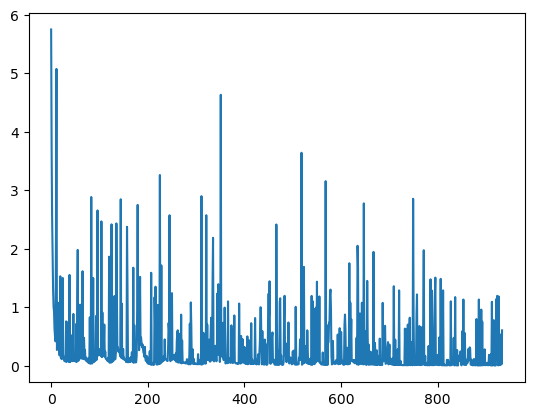

In [8]:
plt.plot(loss_history)

In [9]:
import pysvelte

def display_vectors(x,d=4):
    weights = torch.sum(x**3,dim=0)
    strongest = torch.argsort(weights)[-d:].flip(dims=(0,))
    plt.imshow(x.transpose(0,1)[strongest])
    plt.show()


def show_attention_pattern_for_input(model, inputs,outputs):
    model_cache={}
    model.cache_all(model_cache) # remove_batch_dim=True
    model(inputs)
    model.reset_hooks()
    
    pysvelte.AttentionMulti(tokens=[str(x) for x in inputs[0].tolist()], attention=model_cache['blocks.0.attn.hook_attn'][0].permute(1, 2, 0)).show()
    display_vectors(model_cache["blocks.0.mlp.hook_post"][0])
    
    pysvelte.AttentionMulti(tokens=[str(x) for x in inputs[0].tolist()], attention=model_cache['blocks.1.attn.hook_attn'][0].permute(1, 2, 0)).show()
    display_vectors(model_cache["blocks.1.mlp.hook_post"][0])
    
    pysvelte.AttentionMulti(tokens=[str(x) for x in inputs[0].tolist()], attention=model_cache['blocks.2.attn.hook_attn'][0].permute(1, 2, 0)).show()
    display_vectors(model_cache["blocks.2.mlp.hook_post"][0])

In [33]:
inputs,outputs = gen(3,  tiny_model.cfg.d_vocab, 5, 3, 40)
output_logits = tiny_model(inputs, return_type="logits")
predictions = output_logits.argmax(dim=2)

[[  1   3   1 199   2   3   0   0   1   2   2   0   2   3   0   3   0   1
    0   1   1   0   2   1   3   3   2   0   0   1   0   1   1   1   1   3
    2   2   2   1   3   2   3   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   1   0   0   0   0   0]]


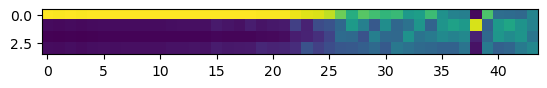

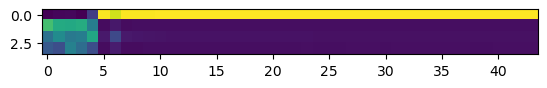

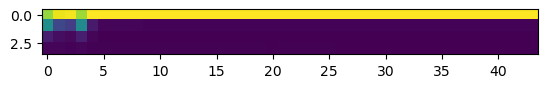

In [34]:
print(np.array([
    inputs[0].tolist(),
    outputs[0].tolist(),
    predictions[0].tolist()
  ]))

show_attention_pattern_for_input(tiny_model,inputs,outputs)

In [ ]:
embeds = tiny_model.embed.W_E.detach().cpu()
embeds = embeds[:,torch.argsort(embeds[0])]
pca = torch.pca_lowrank(embeds,center=True,q=20)[0]

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(pca,aspect=0.05,interpolation="nearest")
#plt.plot(pca[:,0]-pca[:,1])

In [ ]:
#model_cache={}
#tiny_model.cache_all(model_cache) # remove_batch_dim=True
inputs,outputs = gen(100,vocab_size,60)
output = tiny_model(inputs)
torch.mean(output**3).backward()
print((tiny_model.blocks[2].attn.z.grad.mean(dim=(0,1,3))))
#tiny_model.reset_hooks()

In [ ]:
print(model_cache["blocks.0.attn.hook_z"][0].shape)
print(model_cache["blocks.0.hook_attn_out"][0].shape)
print(model_cache["blocks.0.hook_attn_out"][0].shape)
print(model_cache["blocks.0.mlp.hook_pre"][0].shape)

In [ ]:
model_cache.keys()

In [ ]:
model_cache["blocks.0.attn.hook_z"].grad

In [ ]:
torch.tensor([2,3,4,5])>>2

In [ ]:
tiny_model(torch.tensor([[5,4,2,7,8,2,199, 2, 2, 4, 5, 7]])).argmax(dim=2)